# keras Sequential

## 라이브러리 & 데이터 불러오기

In [1]:
import pandas as pd

# import nltk
# from nltk.tokenize import TreebankWordTokenizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score

In [2]:
# 전처리 끝낸 데이터 불러오기
raw = pd.read_csv('/Users/mac/AIFFEL/hackathon/new_musinsa(upcycling).csv', engine='python')
print(raw.shape)
raw.head()

(715, 12)


,Unnamed: 0,user,color,contents,category,ratings,gender,price,style,up_check,brand,url
0,0,멤버_464f9cc84f7d,기타,면,상의,5,남자,39000,0,0,119레오,https://www.musinsa.com/app/goods/1876547/0
1,1,멤버_464f9cc84f7d,카키,면,하의,5,남자,42000,0,0,119레오,https://www.musinsa.com/app/goods/2396824/0
2,2,멤버_464f9cc84f7d,기타,면,모자,5,남자,59000,0,0,119레오,https://www.musinsa.com/app/goods/2428013/0
3,3,멤버_464f9cc84f7d,블랙,면,상의,5,남자,35000,0,0,119레오,https://www.musinsa.com/app/goods/470357/0
4,4,멤버_464f9cc84f7d,아이보리,면 아라미드,가방,5,남자,48000,1,1,119레오,https://www.musinsa.com/app/goods/1766332/0


In [3]:
# 불필요한 컬럼 제거
raw.drop(['Unnamed: 0', 'user', 'up_check', 'url'], axis=1, inplace=True)
raw.head()

,color,contents,category,ratings,gender,price,style,brand
0,기타,면,상의,5,남자,39000,0,119레오
1,카키,면,하의,5,남자,42000,0,119레오
2,기타,면,모자,5,남자,59000,0,119레오
3,블랙,면,상의,5,남자,35000,0,119레오
4,아이보리,면 아라미드,가방,5,남자,48000,1,119레오


## 라벨 인코딩

In [4]:
brand_unique = raw['brand'].unique()

brand_to_idx = {v:k for k,v in enumerate(brand_unique)}

temp_brand_data = raw['brand'].map(brand_to_idx.get).dropna()
if len(temp_brand_data) == len(raw):   # 모든 row가 정상적으로 인덱싱되었다면
    print('brand column indexing OK!!')
    raw['brand'] = temp_brand_data   # data['brand']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('brand column indexing Fail!!')


brand column indexing OK!!


In [5]:
# 라벨 인코딩을 하기 위한 dictionary map 생성 함수
def make_label_map(dataframe):
    label_maps ={}
    for col in dataframe.columns:
        if dataframe[col].dtype=='object':
            label_map = {'unknown':0}
            for i, key in enumerate(dataframe[col].unique()):
                label_map[key] = i+1  #새로 등장하는 유니크 값들에 대해 1부터 1씩 증가시켜 키값을 부여해줍니다.
            label_maps[col] = label_map
    return label_maps

In [6]:
# 각 범주형 변수에 인코딩 값을 부여하는 함수
def label_encoder(dataframe, label_map):
    for col in dataframe.columns:
        if dataframe[col].dtype=='object':
            dataframe[col] = dataframe[col].map(label_map[col])
            dataframe[col] = dataframe[col].fillna(label_map[col]['unknown']) #혹시 모를 결측값은 unknown의 값(0)으로 채워줍니다.
    return dataframe

In [7]:
# train 데이터 라벨 인코딩
label_map = make_label_map(raw) # train 사용해 label map 생성
raw = label_encoder(raw, label_map) # train 라벨 인코딩

In [8]:
raw.head()

,color,contents,category,ratings,gender,price,style,brand
0,1,1,1,5,1,39000,0,0
1,2,1,2,5,1,42000,0,0
2,1,1,3,5,1,59000,0,0
3,3,1,1,5,1,35000,0,0
4,4,2,4,5,1,48000,1,0


In [9]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   color     715 non-null    int64
 1   contents  715 non-null    int64
 2   category  715 non-null    int64
 3   ratings   715 non-null    int64
 4   gender    715 non-null    int64
 5   price     715 non-null    int64
 6   style     715 non-null    int64
 7   brand     715 non-null    int64
dtypes: int64(8)
memory usage: 44.8 KB


## 정규화

In [10]:
# 수치형 데이터 정규화
# min-max 정규화 : 수치형 데이터의 값을 0~1 사이의 값으로 변환해준다.
# X' = (X-Min) / (Max-Min)

from sklearn.preprocessing import MinMaxScaler

num_features = ['price']

scaler = MinMaxScaler()
raw[num_features] = scaler.fit_transform(raw[num_features])
raw.head()

,color,contents,category,ratings,gender,price,style,brand
0,1,1,1,5,1,0.017942,0,0
1,2,1,2,5,1,0.019326,0,0
2,1,1,3,5,1,0.027167,0,0
3,3,1,1,5,1,0.016097,0,0
4,4,2,4,5,1,0.022093,1,0


## x_data / y_data 분리

In [11]:
import numpy as np

raw_np = raw.to_numpy()
print(raw_np)

[[ 1.          1.          1.         ...  0.01794213  0.
   0.        ]
 [ 2.          1.          2.         ...  0.01932584  0.
   0.        ]
 [ 1.          1.          3.         ...  0.02716687  0.
   0.        ]
 ...
 [ 8.          6.          3.         ...  0.01332975  0.
   5.        ]
 [ 3.          3.          1.         ...  0.06360461  0.
   5.        ]
 [ 3.         10.          4.         ...  0.01794213  0.
   5.        ]]


In [12]:
x_data = raw_np[:, :-1].astype(float)
y_data = raw_np[:, -1]

print(x_data.shape, y_data.shape)
print("\n")
y_data

(715, 7) (715,)




array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

## brand 원핫인코딩

In [13]:
# 원핫인코딩
from tensorflow.keras.utils import to_categorical
y_onehot = to_categorical(y_data, num_classes=6)
print(y_onehot)

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


## 모델 학습

In [14]:
X_train, X_test, y_train, y_test = train_test_split(x_data, 
                                                    y_onehot, 
                                                    test_size=0.2, 
                                                    random_state=4, 
                                                    stratify=y_onehot)
print(X_train.shape)
print(X_test.shape)


(572, 7)
(143, 7)


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers

model = Sequential()

model.add(Dense(16, activation='relu', input_dim=7))
model.add(Dense(6, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                128       
                                                                 
 dense_1 (Dense)             (None, 6)                 102       
                                                                 
Total params: 230
Trainable params: 230
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer = 'adam', 
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

hist = model.fit(X_train, y_train, epochs=800)

Epoch 1/800
18/18 [==============================] - 0s 2ms/step - loss: 4.8239 - accuracy: 0.2448
Epoch 2/800
18/18 [==============================] - 0s 2ms/step - loss: 3.9328 - accuracy: 0.2552
Epoch 3/800
18/18 [==============================] - 0s 2ms/step - loss: 3.2630 - accuracy: 0.2622
Epoch 4/800
18/18 [==============================] - 0s 2ms/step - loss: 2.8299 - accuracy: 0.2570
Epoch 5/800
18/18 [==============================] - 0s 2ms/step - loss: 2.5546 - accuracy: 0.2552
Epoch 6/800
18/18 [==============================] - 0s 2ms/step - loss: 2.3433 - accuracy: 0.2692
Epoch 7/800
18/18 [==============================] - 0s 2ms/step - loss: 2.1801 - accuracy: 0.2622
Epoch 8/800
18/18 [==============================] - 0s 1ms/step - loss: 2.0538 - accuracy: 0.2832
Epoch 9/800
18/18 [==============================] - 0s 2ms/step - loss: 1.9488 - accuracy: 0.2657
Epoch 10/800
18/18 [==============================] - 0s 2ms/step - loss: 1.8538 - accuracy: 0.2780
Epoch 11/

18/18 [==============================] - 0s 1ms/step - loss: 1.4347 - accuracy: 0.4073
Epoch 84/800
18/18 [==============================] - 0s 1ms/step - loss: 1.4348 - accuracy: 0.4056
Epoch 85/800
18/18 [==============================] - 0s 1ms/step - loss: 1.4367 - accuracy: 0.4038
Epoch 86/800
18/18 [==============================] - 0s 1ms/step - loss: 1.4375 - accuracy: 0.4038
Epoch 87/800
18/18 [==============================] - 0s 1ms/step - loss: 1.4354 - accuracy: 0.4161
Epoch 88/800
18/18 [==============================] - 0s 1ms/step - loss: 1.4284 - accuracy: 0.4161
Epoch 89/800
18/18 [==============================] - 0s 1ms/step - loss: 1.4335 - accuracy: 0.4196
Epoch 90/800
18/18 [==============================] - 0s 1ms/step - loss: 1.4320 - accuracy: 0.4056
Epoch 91/800
18/18 [==============================] - 0s 1ms/step - loss: 1.4300 - accuracy: 0.4056
Epoch 92/800
18/18 [==============================] - 0s 1ms/step - loss: 1.4293 - accuracy: 0.4073
Epoch 93/800


18/18 [==============================] - 0s 1ms/step - loss: 1.3901 - accuracy: 0.4283
Epoch 165/800
18/18 [==============================] - 0s 1ms/step - loss: 1.3889 - accuracy: 0.4476
Epoch 166/800
18/18 [==============================] - 0s 1ms/step - loss: 1.3877 - accuracy: 0.4371
Epoch 167/800
18/18 [==============================] - 0s 1ms/step - loss: 1.3882 - accuracy: 0.4248
Epoch 168/800
18/18 [==============================] - 0s 1ms/step - loss: 1.3906 - accuracy: 0.4423
Epoch 169/800
18/18 [==============================] - 0s 1ms/step - loss: 1.3859 - accuracy: 0.4406
Epoch 170/800
18/18 [==============================] - 0s 1ms/step - loss: 1.3881 - accuracy: 0.4336
Epoch 171/800
18/18 [==============================] - 0s 1ms/step - loss: 1.3878 - accuracy: 0.4458
Epoch 172/800
18/18 [==============================] - 0s 1ms/step - loss: 1.3872 - accuracy: 0.4441
Epoch 173/800
18/18 [==============================] - 0s 1ms/step - loss: 1.3854 - accuracy: 0.4476
Epoc

18/18 [==============================] - 0s 1ms/step - loss: 1.3533 - accuracy: 0.4703
Epoch 246/800
18/18 [==============================] - 0s 2ms/step - loss: 1.3484 - accuracy: 0.4510
Epoch 247/800
18/18 [==============================] - 0s 1ms/step - loss: 1.3485 - accuracy: 0.4580
Epoch 248/800
18/18 [==============================] - 0s 1ms/step - loss: 1.3456 - accuracy: 0.4528
Epoch 249/800
18/18 [==============================] - 0s 1ms/step - loss: 1.3471 - accuracy: 0.4563
Epoch 250/800
18/18 [==============================] - 0s 1ms/step - loss: 1.3451 - accuracy: 0.4615
Epoch 251/800
18/18 [==============================] - 0s 1ms/step - loss: 1.3459 - accuracy: 0.4615
Epoch 252/800
18/18 [==============================] - 0s 1ms/step - loss: 1.3451 - accuracy: 0.4580
Epoch 253/800
18/18 [==============================] - 0s 1ms/step - loss: 1.3439 - accuracy: 0.4633
Epoch 254/800
18/18 [==============================] - 0s 1ms/step - loss: 1.3446 - accuracy: 0.4598
Epoc

18/18 [==============================] - 0s 1ms/step - loss: 1.2604 - accuracy: 0.5280
Epoch 327/800
18/18 [==============================] - 0s 1ms/step - loss: 1.2607 - accuracy: 0.5087
Epoch 328/800
18/18 [==============================] - 0s 1ms/step - loss: 1.2595 - accuracy: 0.5245
Epoch 329/800
18/18 [==============================] - 0s 1ms/step - loss: 1.2590 - accuracy: 0.5087
Epoch 330/800
18/18 [==============================] - 0s 1ms/step - loss: 1.2584 - accuracy: 0.5227
Epoch 331/800
18/18 [==============================] - 0s 1ms/step - loss: 1.2580 - accuracy: 0.5157
Epoch 332/800
18/18 [==============================] - 0s 1ms/step - loss: 1.2540 - accuracy: 0.5210
Epoch 333/800
18/18 [==============================] - 0s 1ms/step - loss: 1.2547 - accuracy: 0.5192
Epoch 334/800
18/18 [==============================] - 0s 1ms/step - loss: 1.2545 - accuracy: 0.5035
Epoch 335/800
18/18 [==============================] - 0s 1ms/step - loss: 1.2553 - accuracy: 0.5262
Epoc

18/18 [==============================] - 0s 1ms/step - loss: 1.2155 - accuracy: 0.5315
Epoch 408/800
18/18 [==============================] - 0s 1ms/step - loss: 1.2161 - accuracy: 0.5262
Epoch 409/800
18/18 [==============================] - 0s 1ms/step - loss: 1.2142 - accuracy: 0.5385
Epoch 410/800
18/18 [==============================] - 0s 1ms/step - loss: 1.2168 - accuracy: 0.5245
Epoch 411/800
18/18 [==============================] - 0s 1ms/step - loss: 1.2177 - accuracy: 0.5245
Epoch 412/800
18/18 [==============================] - 0s 1ms/step - loss: 1.2129 - accuracy: 0.5262
Epoch 413/800
18/18 [==============================] - 0s 1ms/step - loss: 1.2143 - accuracy: 0.5245
Epoch 414/800
18/18 [==============================] - 0s 1ms/step - loss: 1.2207 - accuracy: 0.5157
Epoch 415/800
18/18 [==============================] - 0s 1ms/step - loss: 1.2159 - accuracy: 0.5402
Epoch 416/800
18/18 [==============================] - 0s 1ms/step - loss: 1.2134 - accuracy: 0.5280
Epoc

18/18 [==============================] - 0s 1ms/step - loss: 1.1950 - accuracy: 0.5350
Epoch 489/800
18/18 [==============================] - 0s 1ms/step - loss: 1.1944 - accuracy: 0.5385
Epoch 490/800
18/18 [==============================] - 0s 1ms/step - loss: 1.1979 - accuracy: 0.5280
Epoch 491/800
18/18 [==============================] - 0s 1ms/step - loss: 1.1965 - accuracy: 0.5297
Epoch 492/800
18/18 [==============================] - 0s 1ms/step - loss: 1.1962 - accuracy: 0.5280
Epoch 493/800
18/18 [==============================] - 0s 1ms/step - loss: 1.1979 - accuracy: 0.5350
Epoch 494/800
18/18 [==============================] - 0s 1ms/step - loss: 1.1934 - accuracy: 0.5280
Epoch 495/800
18/18 [==============================] - 0s 1ms/step - loss: 1.1937 - accuracy: 0.5280
Epoch 496/800
18/18 [==============================] - 0s 1ms/step - loss: 1.1936 - accuracy: 0.5315
Epoch 497/800
18/18 [==============================] - 0s 1ms/step - loss: 1.1942 - accuracy: 0.5350
Epoc

18/18 [==============================] - 0s 1ms/step - loss: 1.1814 - accuracy: 0.5402
Epoch 570/800
18/18 [==============================] - 0s 1ms/step - loss: 1.1864 - accuracy: 0.5297
Epoch 571/800
18/18 [==============================] - 0s 1ms/step - loss: 1.1891 - accuracy: 0.5297
Epoch 572/800
18/18 [==============================] - 0s 1ms/step - loss: 1.1823 - accuracy: 0.5385
Epoch 573/800
18/18 [==============================] - 0s 2ms/step - loss: 1.1850 - accuracy: 0.5245
Epoch 574/800
18/18 [==============================] - 0s 1ms/step - loss: 1.1826 - accuracy: 0.5455
Epoch 575/800
18/18 [==============================] - 0s 1ms/step - loss: 1.1812 - accuracy: 0.5280
Epoch 576/800
18/18 [==============================] - 0s 1ms/step - loss: 1.1855 - accuracy: 0.5385
Epoch 577/800
18/18 [==============================] - 0s 2ms/step - loss: 1.1834 - accuracy: 0.5367
Epoch 578/800
18/18 [==============================] - 0s 1ms/step - loss: 1.1805 - accuracy: 0.5245
Epoc

18/18 [==============================] - 0s 1ms/step - loss: 1.1712 - accuracy: 0.5385
Epoch 651/800
18/18 [==============================] - 0s 2ms/step - loss: 1.1733 - accuracy: 0.5350
Epoch 652/800
18/18 [==============================] - 0s 1ms/step - loss: 1.1732 - accuracy: 0.5315
Epoch 653/800
18/18 [==============================] - 0s 1ms/step - loss: 1.1708 - accuracy: 0.5262
Epoch 654/800
18/18 [==============================] - 0s 1ms/step - loss: 1.1714 - accuracy: 0.5367
Epoch 655/800
18/18 [==============================] - 0s 2ms/step - loss: 1.1746 - accuracy: 0.5297
Epoch 656/800
18/18 [==============================] - 0s 1ms/step - loss: 1.1791 - accuracy: 0.5122
Epoch 657/800
18/18 [==============================] - 0s 1ms/step - loss: 1.1752 - accuracy: 0.5402
Epoch 658/800
18/18 [==============================] - 0s 1ms/step - loss: 1.1798 - accuracy: 0.5280
Epoch 659/800
18/18 [==============================] - 0s 1ms/step - loss: 1.1738 - accuracy: 0.5315
Epoc

18/18 [==============================] - 0s 1ms/step - loss: 1.1643 - accuracy: 0.5227
Epoch 732/800
18/18 [==============================] - 0s 2ms/step - loss: 1.1664 - accuracy: 0.5262
Epoch 733/800
18/18 [==============================] - 0s 1ms/step - loss: 1.1665 - accuracy: 0.5332
Epoch 734/800
18/18 [==============================] - 0s 1ms/step - loss: 1.1643 - accuracy: 0.5280
Epoch 735/800
18/18 [==============================] - 0s 1ms/step - loss: 1.1654 - accuracy: 0.5297
Epoch 736/800
18/18 [==============================] - 0s 1ms/step - loss: 1.1662 - accuracy: 0.5262
Epoch 737/800
18/18 [==============================] - 0s 1ms/step - loss: 1.1644 - accuracy: 0.5297
Epoch 738/800
18/18 [==============================] - 0s 1ms/step - loss: 1.1658 - accuracy: 0.5367
Epoch 739/800
18/18 [==============================] - 0s 1ms/step - loss: 1.1661 - accuracy: 0.5227
Epoch 740/800
18/18 [==============================] - 0s 1ms/step - loss: 1.1672 - accuracy: 0.5350
Epoc

In [17]:
score = model.evaluate(X_test, y_test, verbose=1)
print("accuracy : ", score[1], "loss :", score[0])

5/5 [==============================] - 0s 2ms/step - loss: 1.3080 - accuracy: 0.4895
accuracy :  0.4895104765892029 loss : 1.308011531829834


## 학습 시각화

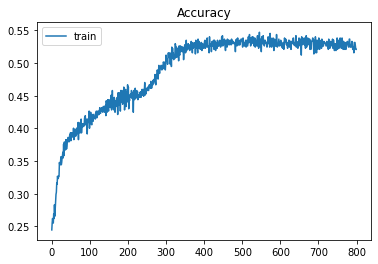

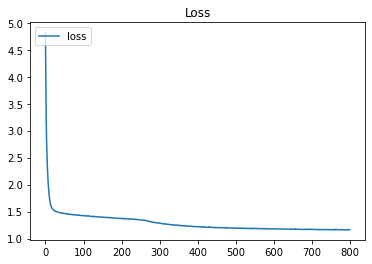

In [18]:
import matplotlib.pyplot as plt

# loss : 훈련 손실값
# acc : 훈련 정확도
# val_loss : 검증 손실값
# val_acc : 검증 정확도

plt.plot(hist.history['accuracy'])
#plt.plot(hist.history['val_acc'])
plt.title('Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
#plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.legend(['loss'], loc='upper left')
plt.show()

In [19]:
# 모델 저장하기
from keras.models import load_model
model.save('keras_sequential02.h5')